# Imaging Edge Notebook 2: Convert Abstracts to Trends

ImagingEdge detects trends in the radiological research literature before they become mainstream publications, patents and products.

*Part 2: (this notebook) of the app measures trends in the abstracts scraped from PubMed*

Other parts:

Part 1: Scrape PubMed

Part 3: Build graph connecting search terms and trends

Part 4: Graph "learns" from unstructured sources

### Created by Eric Barnhill for Insight Health Data Science
#### 2018 No License

Documentation follows the [Google Python Style Guide](http://google.github.io/styleguide/pyguide.html)

In [95]:
# SETUP
%run rtr.ipynb
from sqlalchemy import and_
import pickle
import logging
import datetime
YEAR = 2015
PATH = "/home/ericbarnhill/Documents/code/insight/rtr/" + str(YEAR) + "/"
if not os.path.exists(PATH):
    os.mkdir(PATH)
os.chdir(PATH)
logfile = os.getcwd() + '/bow.log'
print("Logfile path: ", logfile)
logging.basicConfig(filename=logfile,level=logging.DEBUG)

Logfile path:  /home/ericbarnhill/Documents/code/insight/rtr/2015/bow.log


## Measure ngram trends within abstract rolling windows

Find most common BOW terms from Diagnostic Imaging abstracts

In [96]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from nltk import ngrams
from nltk.stem import WordNetLemmatizer

english_stops = set(stopwords.words('english'))
# create radiology stops
radiology_stops = ['pci', 'mm', 'auroc', 'roc', 'mri', 'ct', 'pet', 'us', \
                  'p', 'significant', 'significantly', 't', 'ci', 'highly', 'mm', \
                  'considered', 'increase', 'increased', 'decrease', \
                  'decreased', 'measure', 'group', 'standard', 'gold', \
                  'ground', 'truth', 'patient', 'inc', 'cad', \
                  'positive', 'negative', 'year', 'study', \
                  'one', 'two', 'three', 'wiley', 'springer', 'patient', \
                  'diagnosis', 'evaluate', 'statistical', 'statistically', \
                  'ass', 'cohort', 'confidence', 'interval', 'primary', \
                  'outcome', 'increasing', 'decreasing', 'clinical', \
                  'r', 'correlation', 'sample', 'size', 'compared', \
                  'randomly', 'divided', 'baseline', 'case', 'report', \
                  'outcome', 'also', 'half', 'may', 'can', 'powerful', \
                  'tool', 'ass', 'informed', 'consent', 'age', 'sex',
                  'rare', 'cause', 'risk', 'likelihood', 'ratio', 'patients', \
                  'whether', 'regarding', 'including', 'results', 'result', 'mi', \
                  'data', 'set', 'ex', 'in', 'pro', 'mr', 'scan', \
                  'showed', 'studies', 'accuracy', 'performed', 'used', \
                  'determine', 'higher', 'lower', 'male', 'female', \
                  'important', 'role', 'remains', 'unclear', \
                  'range', 'years', 'months', 'days', 'young', 'old', \
                  'modality', 'modalities', 'oct', 'hcc', 'among', \
                  'could', 'useful', 'groups', 'respectively', \
                  'ifg', 'octa', 'mra', 'using', 'suggest', \
                  'revealed', 'options', 'treatment', 'findings', \
                  'medical', 'image', 'using', 'often', \
                  'underwent', 'high', 'low', 'assessed', 'method', \
                  'better', 'per', 'case', 'cases']

def get_bow(retained_abstracts, ngram_range=range(1), from_sql = False,
            dedupe = True, debug=False):
    """Get bag of words
        
    Args:
        retained_abstracts: List of retained abstracts 
            following the expected dictionary form.
        
    Returns:
        Counter object containing bag of words.
    """
    BOW_all = Counter()
    for i, abst in enumerate(retained_abstracts):
        if (i) % 1000 == 0:
            logging.info("Abstract " + str(i) + "...")
        if from_sql:
            abst_txt = ''.join(abst[0])
        else:
            abst_txt = ''.join(abst['Abstract'])
        abst_tokens = word_tokenize(abst_txt)
        # already lower case from earlier parsing
        # Retain alphabetic words: alpha_only
        abst_alpha = [t for t in abst_tokens if t.isalpha()]
        # Remove all stop words: no_stops
        abst_no_eng_stops = [t for t in abst_alpha if t not in english_stops]
        abst_no_stops = [t for t in abst_no_eng_stops if t not in radiology_stops]
        # get rid of individual letters
        abst_no_stops = [t for t in abst_no_stops if len(t) > 1]
        # Instantiate the WordNetLemmatizer - decided against
        #wordnet_lemmatizer = WordNetLemmatizer()
        # Lemmatize all tokens into a new list: lemmatized
        #abst_lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in abst_no_stops]
        # Create the bag-of-words for each ngram: bow
        bow_ngrams = []
        for n in ngram_range:
            if debug:
                print("ngram length:", n)
            abst_ngrams = ngrams(abst_no_stops, n)
            #abst_ngrams = ngrams(abst_lemmatized, n)
            bow_ngrams.append(Counter(abst_ngrams))
        # de-dupe by removing smaller ngrams contained within larger
        if dedupe:
            range_max = max(ngram_range)
            range_min = min(ngram_range)
            num_ngrams_sets = len(bow_ngrams)
            for n in range(1, num_ngrams_sets):
                for larger_key in list(bow_ngrams[n]):
                    for smaller_key in list(bow_ngrams[n-1]):
                        if ' '.join(smaller_key) in ' '.join(larger_key):
                            del bow_ngrams[n-1][smaller_key]
        for bow_ngram in bow_ngrams:
            BOW_all += bow_ngram
    return BOW_all

## Join BOWs across rolling windows

Next is to compare the normalized frequency of BOW ngrams across two or more time periods. First step is to filter the BOW for each window to only contain common ngrams. The method will produce some summary stats on that. 



In [97]:
def merge_bows(bows_unfilt):
    """Filter list BOWs so that only common terms are contained
        
    Args:
        list of unfiltered BOW dicts
        
    Returns:
        list of filtered BOW dicts
    """ 
    # allocate filtered bows
    n_bows = len(bows_unfilt)
    bows_filt = []
    for n in range(n_bows):
        bows_filt.append({})
    # create intersected set of keys
    intersected_keys = []
    for bow in bows_unfilt:
        if not intersected_keys:
            logging.info('initializing intersected keys')
            intersected_keys = bow.keys()
            logging.info('length: ' + str(len(intersected_keys)))
        else:
            logging.info('updating intersected keys')
            logging.info('length next set: ' + str(len(bow.keys())))
            intersected_keys = intersected_keys & bow.keys()
            logging.info('length intersected:' +  str(len(intersected_keys)))
    # filter bows to only contain intersecting keys:
    bows_filt = []
    for bow in bows_unfilt:
        bow_filt = { key: bow[key] for key in intersected_keys }
        bows_filt.append(bow_filt)
    return bows_filt 

## Draw abstracts in rolling windows from the SQL store:

In [98]:
def get_rolling_window_abstracts_sql(start_date, n_windows, n_months, connection, rtr_abstracts):
    """Pull abstracts within rolling date windows from the SQL database
        
    Args:
        start_date: start date for all windows
        n_windows: number of rolling windows
        n_months: number of months in each window
        connection: SQLAlchemy connection object
        rtr_abstracts = RTR abstracts table object
        
    Returns:
        List of window records, one per rolling window
    """
    window_records = []
    for n in range(n_windows):
        start = start_date + n*relativedelta(months=+1)
        end = start + relativedelta(months=+n_months)
        logging.info("Query from " + str(start) + " to " + str(end))
        stmt = select([rtr_abstracts])
        stmt = stmt.where(
            and_(rtr_abstracts.columns.date > start,
                 rtr_abstracts.columns.date < end
                 )
        )
        results = connection.execute(stmt).fetchall()
        window_records.append(results)
        logging.info("Length of results: " + str(len(results)))
    return window_records

def get_record_counts(records):
    """Returns record counts for rolling windows. Used to calibrate monthly mentions.
        
    Args:
        List of window records, one per rolling window (from get_rolling_window_abstracts_sql)
    """
    record_counts = []
    for record_set in records:
        record_counts.append(len(record_set))
    return record_counts

In [99]:
def get_rolling_window_abstracts_direct(start_date, n_windows, n_months, 
                                        mesh_terms=['radiology', 'diagnostic imaging']):
    """Pull abstracts within rolling date windows directly from PubMed.
    
    Used to check the performance of the calls to the SQL database.
    
    Args:
        start_date: start date for all windows
        n_windows: number of rolling windows
        n_months: number of months in each window
        mesh_terms: search terms used for PubMed
        
    Returns:
        List of window records, one per rolling window
    """
    window_records = []
    for n in range(n_windows):
        start = start_date + n*relativedelta(months=+1)
        end = start + relativedelta(months=+n_months)
        results = scrape_pubmed_abstracts(start, end, mesh_terms, debug)
        window_records.append(results)
        print("Length of results: ", len(results))
    return window_records

In [100]:
def sql_records_setup_pull(n_windows, n_months, start_date):
    """Pull abstracts within rolling date windows directly from PubMed.
    
    Used to check the performance of the calls to the SQL database.
    
    Args:
        start_date: start date for all windows
        n_windows: number of rolling windows
        n_months: number of months in each window
        mesh_terms: search terms used for PubMed
        
    Returns:
        List of window records, one per rolling window
    """
    N_WINDOWS = n_windows
    N_MONTHS = n_months
    dbname = 'rtr_db'
    username = 'ericbarnhill'
    pswd = 'carter0109'
    metadata, engine, connection = create_rtr_sql_engine(dbname, username, pswd)
    rtr_abstracts = check_create_abstracts_table(metadata, engine)
    window_records = get_rolling_window_abstracts_sql(start_date, N_WINDOWS, N_MONTHS,
                                                  connection, rtr_abstracts)
    # close and dispose connections
    connection.close()
    engine.dispose()
    return window_records

def records_to_bows(window_records, ngram_range = range(2,4), dedupe = True):
    """Converts PubMed scrapes to Bag-Of-Words ngrams. These are then used to build the graph.
    
    Filters BOW lists as it proceeds, retaining only persistent terms, to reduce memory burdens.
    
    Args:
        window_records = list of rolling window records
        ngram_range = range of ngrams considered by the algorithm
        dedupe = performing deduping at this stage. Thus far, this shows inferior performance
            to performing deduping after trends have been measured.
        
    Returns:
        List of window records, one per rolling window
    """
    bows_filt = []
    for records in window_records:
        bow = get_bow(records, ngram_range, from_sql=True, dedupe=dedupe)
        bows_filt.append(bow)
        bows_filt = merge_bows(bows_filt)
        # save partial results, so that partial runs can be inspected:
        with open("bows_filt_temp.pickle", "wb") as fp:
            pickle.dump(bows_filt, fp)
        logging.info("bag of words length: " + str(len(bow)))
    return bows_filt

In [123]:
def measure_bow_trends(bows, record_counts, log_trends=True, debug=False):
    """Convert filtered list to trends
    
    Methodology:
        get slope and residuals of linear fit from previous time periods
        normalized slope - strength of trend
        normalized residual - uncertainty of fit
        trend_score =  normlized slope divided by normalized residual
        
    Args:
        bows: filtered BOW dicts.
        log: measure log trends (goodness of fit to exponential trend).
        debug: print lots of variables.
        
    Returns:
        single BOW dict containing gradients
    """    
    # some adjustable constants
    MIN_TOTAL_MENTIONS = 50
    MIN_PER_PERIOD = 5
    bow_trends = {}
    # keys from filtered dicts are all identical, so just need any one
    keys = bows[0].keys()
    n_keys = len(keys)
    # preallocate points vector
    # dummy date variable for regression
    x = np.arange(len(bows))
    trends = {}
    pct_prev = 0
    UPDATE = 5
    record_counts = np.array(record_counts)
    # normalize record counts
    record_counts = record_counts / np.mean(record_counts)
    for j, key in enumerate(keys):
        pct = round((j/n_keys)*100)
        if pct % UPDATE == 0:
            if pct != pct_prev:
                logging.info(str(pct) + "% complete...")
                pct_prev = pct
        y = np.zeros(len(bows))
        for i, bow in enumerate(bows):
            # loop through the filtered bows of each year
            # assign each # mentions mention to a spot in the array, creating time series
            # normalize by total number of scraped publications that month
            y[i] = np.round(bow[key] / record_counts[i])
        y = np.array(y)
        # filter by total mentions,
        # and min mentions per period
        y_min = np.min(y)
        y_tot = np.sum(y)
        # TESTING
        if y_tot > MIN_TOTAL_MENTIONS and y_min > MIN_PER_PERIOD:
            if debug:
                logging.debug(key + " passed as trend")
            # run it
            if log_trends:
                y = np.log(y)
            # normalize
            y_mean = np.mean(y)
            y_norm = y / y_mean
            # get other filtering criteria
            # fit
            fit = np.polyfit(x, y_norm, 1, full=True)
            # nota bene: polyfit returns highest power first
            slope = fit[0][0]
            intercept = fit[0][1]
            resid = fit[1]
            # avoid distorted divisions when resid is too low
            # disabled for now
            if resid > 1e-3:
                trend_score = slope / resid
            else:
                trend_score = 0
            fit_stats = {'intercept' : intercept, 
                         'slope' : slope, 
                         'resid' : resid, 
                         'trend_score' : trend_score,
                         'vals': y, 
                        'total_mentions': np.sum(y)}
            if debug and sum(y > 0) == 3:
                logging.debug(str(fit))
                logging.debug(str(fit_stats))
            trends.update({key:fit_stats})
        else:
            if debug:
                logging.debug(key + " failed as trend")
    return trends

def bows_to_trends(bows_filt, record_counts, log_trends = False):
    """Converts BOW ngrams to trend measurements.
    
    Args:
        bows_filt = list of rolling window records
        record_counts = vector containin total counts for each window
        log_trends = evalute log trends, modelling trend growth as
            exponential rather than linear. Not currently used in
            production.
        
    Returns:
        List of window records, one per rolling window
    """
    logging.info("filtered bow length: " +  str(len(bows_filt)))
    bow_trends = measure_bow_trends(bows_filt, record_counts, log_trends)
    return bow_trends

In [102]:
# RUN TEST
def run_rolling_window_test_direct(debug=False):
    """Test of building trends directly off PubMed, to check accuracy of SQL calls.
    
    Returns:
        Void
    """
    N_WINDOWS = 2
    N_MONTHS = 2
    start_date = triple2date((2016,1,1))
    mesh_terms = ['radiology', 'diagnostic imaging']
    window_records, statuses = get_rolling_window_abstracts_direct(start_date, N_WINDOWS, N_MONTHS,
                                                        mesh_terms, debug)
    # abstracts 2 bows
    NGRAM_RANGE = range(2, 4)
    bows = []
    for records in window_records:
        bow = get_bow(records, NGRAM_RANGE)
        bows.append(bow)
    bows_filt = merge_bows(bows)
    bow_trends = measure_bow_trends(bows_filt, log_trends = False)
    return bow_trends, window_records

Histogram of test trend slope values

In [103]:
def trend_hist(trends):
    """
    Plots a histogram of trend slope values.
    """
    BINS = 128
    RANGE = [-0.12, 0.12]
    slopes = get_slopes(trends)
    plt.hist(slopes, bins=BINS, range=RANGE)
    plt.show()
    
    RANGE = [-0.3, 0.3]
    trend_scores = get_trend_scores(trends)
    plt.hist(trend_scores, bins=BINS, range=RANGE)
    plt.show()
    
    
def get_slopes(trends):
    """
    Pulls a list of slopes out of the trends and converts to numpy array.
    """
    slopes = np.zeros(len(trends.items()))
    it = 0
    for key, item in trends.items():
        trend_score = item['slope']
        #print(type(trend_score[0]))
        slopes[it] = trend_score
        it += 1
    return slopes

def get_trend_scores(trends):
    """
    Pulls a list of slopes out of the trends and converts to numpy array.
    """
    slopes = np.zeros(len(trends.items()))
    it = 0
    for key, item in trends.items():
        trend_score = item['trend_score']
        #print(type(trend_score[0]))
        slopes[it] = trend_score
        it += 1
    return slopes

Behavior of trends looks convincingly symmetric. While the slopes took a normal distribution, the distribution of slope over dist is unsurprisingly more double-exponential looking.

In [104]:
def first_n_keys(trends, n=5):
    """
    prints out the first n keys of a trend object for manual exploration.
    """
    keys = []
    for i, key in enumerate(trends.keys()):
        print(key)
        keys.append(key)
        if i >= n:
            break
    return keys

Here we give a look at the first five BOW trends. These are unsorted so they should be a "random sample".

In [105]:
def first_bow_trends(bow_trends):
    is_one = []
    first_keys = first_n_keys(bow_trends, 5)
    for key in first_keys:
        item = bow_trends[key]
        print(item)

The slopes are all moderate, with a range of total mentions of the term, so the sample seems reasonably random.

### Correlation of slopes and residuals
Does trend slope correlate with size of residual (in which case trendier topics might just be noising topics)?

In [106]:
def hist_vs_resid(trends, ds = 100):
    """
    Plots trend values versus residual of linear fit for each trend.
    
    Args:
        trends - trends object.
        ds - downsampling factor.
    """
    slope_vals = []
    resid_vals = []
    for key, item in trends.items():
        slope_vals.append(item['slope'])
        resid_vals.append(item['resid'])
    df = pd.DataFrame({'slope_vals': slope_vals, 'resid_vals': resid_vals})
    df_ds = df.iloc[::ds, :]
    f, (ax1, ax2) = plt.subplots(1, 2)
    _ = ax1.scatter(df_ds.slope_vals, df_ds.resid_vals)
    _ = ax1.set_xlabel('slope')
    _ = ax1.set_ylabel('resid')
    #f2, ax2 = plt.subplots(1, 2, 2)
    _ = ax2.scatter(np.abs(df_ds.slope_vals), df_ds.resid_vals)
    _ = ax2.set_xlabel('abs(slope)')
    _ = ax2.set_ylabel('resid')
    f.tight_layout()
    plt.show()
    pearsonr = scipy.stats.pearsonr(df_ds.slope_vals, df_ds.resid_vals)
    pearsonr_mag = scipy.stats.pearsonr(np.abs(df_ds.slope_vals), df_ds.resid_vals)
    return pearsonr, pearsonr_mag

In [107]:
def get_pearsonr(bow_trends):
    pearsonr, pearsonr_mag = hist_vs_resid(bow_trends)
    print("Pearson's r, resid vs slope: ", pearsonr[0])
    print("Pearson's r, resid vs abs(slope)", pearsonr_mag[0])

#### Viewing the top trends

Below the top trending values are analyzed for this test scrape. First we look at the full output of the top 5 stats profiles generated by merge_bows.

In [108]:
def top_n(trends, n):
    trends_sorted = sort_by_trend_score(trends)
    
def sort_by_trend_score(trends):
    trends_scores = []
    trends_keys = []
    trends_y_tot = []
    for key, value in trends.items():
        trends_keys.append(key)
        trends_scores.append(value['trend_score'])
        trends_y_tot.append(value['total_mentions'])
    df = pd.DataFrame({'key':trends_keys, 'score': trends_scores,
                       'total_mentions': trends_y_tot}) 
    df.sort_values(by='score', ascending=False, inplace=True)
    return df

In [109]:
def inspect_results(folder=""):
    with open(folder + "trends.pickle", "rb") as fp:
        trends = pickle.load(fp)
    with open(folder + "records.pickle", "rb") as fp:
        records = pickle.load(fp)
    with open(folder + "bows_filt.pickle", "rb") as fp:
        bows_filt = pickle.load(fp)
    return trends, records, bows_filt

In [110]:
def save_results(folder=""):
    with open(folder + "trends.pickle", "wb") as fp:
        pickle.dump(trends, fp)
    with open(folder + "records.pickle", "wb") as fp:
        pickle.dump(records, fp)
    with open(folder + "df.pickle", "wb") as fp:
        pickle.dump(df, fp)

In [125]:
def run_nb(dedupe = False, year=2016):
    N_WINDOWS = 12
    N_MONTHS = 3
    START_DATE = datetime.date(year,1,1)
    records = sql_records_setup_pull(N_WINDOWS, N_MONTHS, START_DATE)
    record_counts = get_record_counts(records)
    with open("records.pickle", "wb") as fp:
        pickle.dump(records, fp)
    bows_filt = records_to_bows(records, dedupe=dedupe)
    with open("bows_filt.pickle", "wb") as fp:
        pickle.dump(bows_filt, fp)
    trends = bows_to_trends(bows_filt, record_counts)
    with open("trends.pickle", "wb") as fp:
        pickle.dump(trends, fp)
    logging.info("Final number of trends: " + str(len(trends)))
    trend_hist(trends)
    get_pearsonr(trends)
    df = sort_by_trend_score(trends)
    with open("df.pickle", "wb") as fp:
        pickle.dump(df, fp)
    return records, trends, bows_filt, df

def run_nb_post_bows(dedupe = False):
    trends, records, bows_filt = inspect_results(PATH)
    record_counts = get_record_counts(records)
    trends = bows_to_trends(bows_filt, record_counts)
    print("trends length", len(trends))
    with open("trends.pickle", "wb") as fp:
        pickle.dump(trends, fp)
    logging.info("Final number of trends: " + str(len(trends)))
    trend_hist(trends)
    get_pearsonr(trends)
    df = sort_by_trend_score(trends)
    with open("df.pickle", "wb") as fp:
        pickle.dump(df, fp)
    return records, trends, bows_filt, df

In [126]:
def ngram_length_test(bows_filt):
    bow = bows_filt[2]
    c = 0
    for b in list(bow):
        if len(b) == 3:
            c += 1
    print(len(bow) - c, "that are not 3")
    print("out of", len(bow))

trends length 2180


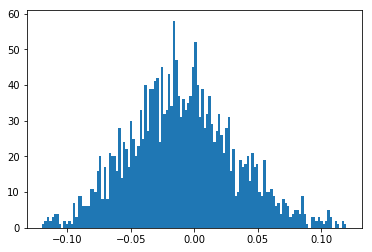

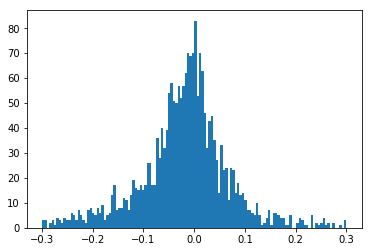

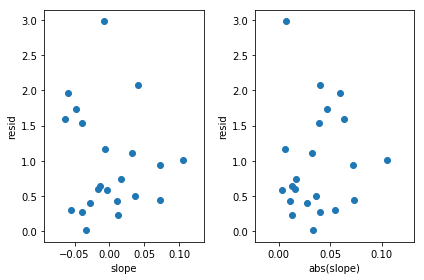

Pearson's r, resid vs slope:  [-0.09917717]
Pearson's r, resid vs abs(slope) [0.07291991]


ValueError: not enough values to unpack (expected 4, got 3)

In [130]:
records, trends, bows_filt, df = run_nb_post_bows(YEAR)

In [122]:
len(bows_filt[0])

10193

In [129]:
df.shape

(1186, 3)